In [6]:
"""Preprocess raw a3d scan images for use in model training."""
import numpy as np
from skimage.transform import resize
from os import path
import json
import tsahelper.tsahelper as tsa
from tqdm import tqdm

from src.config import path_a3d, path_cache, verbose, path_plots, path_logs
from src.constants import IMAGE_DIM
from src.utils import save_image, get_labels


def preprocess_image(img):
    """Scale pixel intensity, and remove mean and variance from image."""
    rescaled_img = tsa.convert_to_grayscale(img)
    normalized_img = tsa.normalize(rescaled_img)
    zero_centered_img = tsa.zero_center(normalized_img)
    return zero_centered_img


def get_upper_bound(s, sensitivity):
    """Get the upper bound given pixel sums along a given dimension."""
    d0 = s - np.roll(s, 10)  # calculate the first derivative
    d1 = d0 - np.roll(d0, 1)  # calculate the second derivative
    d1_bin = d1 < sensitivity  # binarize the second derivative
    return np.argmax(np.arange(s.shape[0]) * (d1_bin ^ np.roll(d1_bin, 1)))  # calculate the cutoff


def get_lower_bound(s, sensitivity):
    """Get the lower bound given pixel sums along a given dimension."""
    d0 = s - np.roll(s, -10)  # calculate the first derivative
    d1 = d0 - np.roll(d0, -1)  # calculate the second derivative
    d1_bin = d1 < sensitivity  # binarize the second derivative
    return np.argmax(np.arange(s.shape[0], 0, -1) * (d1_bin ^ np.roll(d1_bin, -1)))  # calculate the cutoff


def get_bounds(s, sensitivity=.4e-4, n=10):
    """Get lower and upper bounds using moving average derivative."""
    f = s * (s > sensitivity)  # remove layer-level noise
    ma = np.convolve(f, np.ones((n,)) / n, mode='valid')  # moving average
    d = ma - np.roll(ma, -n)
    _buffer = np.floor(n * .8).astype(int)
    return np.argmin(d) - _buffer, np.argmax(d) + n + _buffer

In [2]:
from src.utils import plot_image, animate_scan
from src.pipeline import get_blacklist

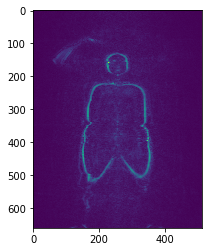

In [3]:
image = tsa.read_data('data/a3d/stage1-a3d-00360f79fd6e02781457eda48f85da90.a3d')
image = image.transpose(2, 0, 1)
plot_image(image[:, :, 250])

In [77]:
filtered = image * (image > 3e-5)

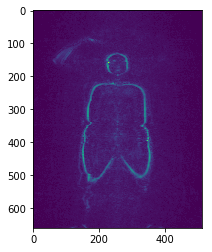

In [78]:
plot_image(filtered[:, :, 250])

In [79]:
from scipy.ndimage.filters import convolve

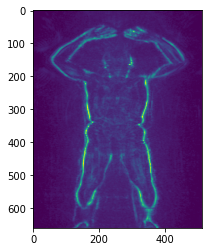

In [80]:
convolved = convolve(filtered, np.ones((3, 3, 3)))
convolved = convolve(convolved, np.ones((3, 3, 3)))
convolved.shape

plot_image(convolved[:, :, 290])

In [112]:
convolved.shape

(660, 512, 512)

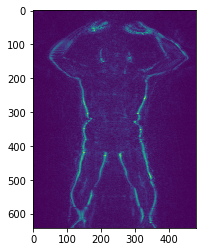

(642, 480, 190)

In [141]:
"""Find the edges of a TSA scan along each dimension and return the cropped image."""
img = convolved

s0 = img.mean(axis=1).mean(axis=1)
s1 = img.mean(axis=0).mean(axis=1)
s2 = img.mean(axis=0).mean(axis=0)

top_border = get_upper_bound(s0, 1.0e-4)
left_border, right_border = get_lower_bound(s1, .9e-7), get_upper_bound(s1, 1.0e-4)
avg_lr_border = np.floor(left_border + (s1.shape[0] - right_border) / 2).astype(int)
front_border, back_border = get_bounds(s2)

resized_image = image[:top_border, avg_lr_border:s1.shape[0] - avg_lr_border, front_border:back_border]
plot_image(resized_image[:, :, 140])
resized_image.shape

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

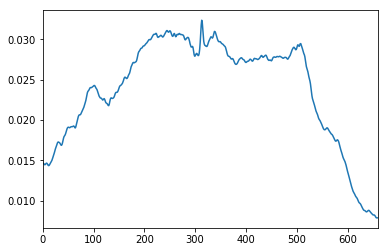

In [83]:
pd.Series(s0).plot.line()
plt.show()

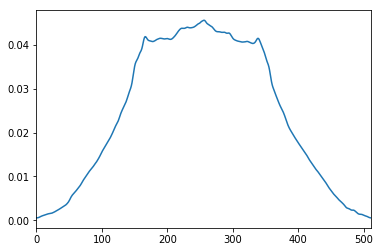

In [84]:
pd.Series(s1).plot.line()
plt.show()

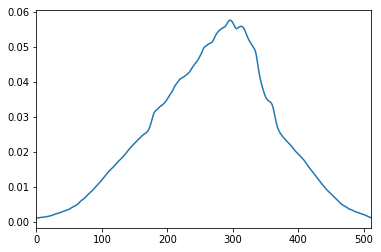

In [85]:
pd.Series(s2).plot.line()
plt.show()